In [115]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.optimize
import random
import math

In [107]:
from spinePopModels.estradiol import estradiol_lvl
from spinePopModels.helpers import find_closest_timestamp
from spinePopModels.gillespie import get_state_change_mat

In [48]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RBF

In [6]:
symbol_matrix = np.array([
    ['deltaM','gammaM2F','gammaM2H','gammaM2S','lambdaM'],
    ['deltaS','gammaS2F','gammaS2H','lambdaS','gammaS2M'],
    ['deltaH','gammaH2F','lambdaH','gammaH2S','gammaH2M'],
    ['deltaF','lambdaF','gammaF2H','gammaF2S','gammaF2M'],
    ['0','betaF','betaH','betaS','betaM']
])

# Load transition probability matrices
DtoP = np.load(os.path.join(os.path.realpath(os.getcwd()), 'spinePopModels/transition_mats/DtoP_transition_matrix.npy'))
PtoE = np.load(os.path.join(os.path.realpath(os.getcwd()), 'spinePopModels/transition_mats/PtoE_transition_matrix.npy'))
EtoM = np.load(os.path.join(os.path.realpath(os.getcwd()), 'spinePopModels/transition_mats/EtoM_transition_matrix.npy'))
MtoD = np.load(os.path.join(os.path.realpath(os.getcwd()), 'spinePopModels/transition_mats/MtoD_transition_matrix.npy'))

mats = [DtoP, PtoE, EtoM, MtoD]

In [18]:
e2_transition_timepoints = np.linspace(0,96,5)[:-1]
transition_e2_lvls = np.array([estradiol_lvl(t) for t in e2_transition_timepoints])
transition_e2_lvls = transition_e2_lvls[:,np.newaxis]

In [27]:
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_decreasing(L) or non_increasing(L)

In [93]:
def spline_interp_conc(t, x):
    if np.size(t) != np.size(x):
        print('Sizes not equal')
        return
    if not monotonic(t):
        sortind = np.argsort(t)
        t = t[sortind]
        x = x[sortind]
    spline_interp = scipy.interpolate.CubicSpline(
        t*24,
        x,
        bc_type='periodic'
    )
    conc = spline_interp(np.arange(0,96.25,0.25))
    return conc

e_times = np.array([0, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4])
e_vals = np.array([10, 20, 25, 40, 10, 5, 10, 5, 10])/1000
p_times = np.array([0,0.5,1.25,1.5,1.6,1.75,0.25,2.0,4.0,3.0,3.5,2.5])
p_vals = np.array([30,10,4,2,3,60,30,5,30,15,30,5])
l_times = np.array([0,1,1.1,0.9,1.5,1.75,2.25,3.0,4.0,2,1.85,1.95])
l_vals = np.array([2,2,2,2,2,40,2,2,2,5,15,10])
f_times = np.array([0,.5,1,1.5,1.75,2.15,2,2.25,3.25,3.75,4,3.5,2.5,2.4,2.3,2.6,2.7])
f_vals = np.array([100,20,20,20,375,375,375,20,20,20,100,100,20,20,20,20,20])
print(
    e_times.shape, e_vals.shape, p_times.shape,
    p_vals.shape, l_times.shape, l_vals.shape,
    f_times.shape, f_vals.shape)

estradiol = spline_interp_conc(e_times, e_vals)
progesterone = spline_interp_conc(p_times, p_vals)
luteinizing = spline_interp_conc(l_times, l_vals)
folliclestim = spline_interp_conc(f_times, f_vals)

# X needs to be (samples, features)
X_conc = np.stack([estradiol, progesterone, luteinizing, folliclestim]).T
X_conc.shape

X_conc[X_conc<0.] = 0.

(9,) (9,) (12,) (12,) (12,) (12,) (17,) (17,)


In [42]:
X_conc[e2_transition_timepoints.astype(int),:].shape

(4, 4)

In [88]:
def fit_glm(X, y):
    """
    Fit a Generalized Linear Model (GLM) with identity link (i.e., linear regression).
    
    Parameters:
        X (np.ndarray): Feature matrix of shape (n_samples, 4)
        y (np.ndarray): Target vector of shape (n_samples,)
        
    Returns:
        weights (np.ndarray): Model weights of shape (5,), including bias term
    """
    n_samples, n_features = X.shape
    assert n_features == 4, "Input must have exactly 4 features per sample."

    # Add bias (intercept) term: shape becomes (n_samples, 5)
    X_aug = np.hstack([np.ones((n_samples, 1)), X])
    
    # Closed-form solution: w = (X^T X)^(-1) X^T y
    XtX = X_aug.T @ X_aug
    Xty = X_aug.T @ y
    weights = np.linalg.inv(XtX) @ Xty
    
    return weights

In [89]:
w = {}
for i in range(np.size(symbol_matrix,0)):
    for j in range(np.size(symbol_matrix,1)):

        y_train = np.zeros(4) * np.nan

        for stage in range(len(mats)):

            param = symbol_matrix[i,j]
            param_at_stage = mats[stage][i,j]

            y_train[stage] = param_at_stage

        # Create function to predict transition probability from the
        # current estradiol level
        # kernel = ExpSineSquared(
        #     length_scale=1.0,
        #     periodicity=4.0
        # )
        # gp = GaussianProcessRegressor(kernel=kernel)
        # gp.fit(
        #     X=X_conc[e2_transition_timepoints.astype(int),:],
        #     y=y_train
        # )
        # score = gp.score(
        #     X_conc[e2_transition_timepoints.astype(int),:],
        #     y_train
        # )
        # y_pred = gp.predict(transition_e2_lvls)
        # print(, score)
        symbol_name = 'w_{}'.format(symbol_matrix[i,j])

        w_ = fit_glm(
            X = X_conc[e2_transition_timepoints.astype(int),:],
            y = y_train
        )

        w[symbol_name] = w_


In [91]:
symbool_star = 'betaM'
x_star = X_conc[15,:].copy() # test point, a set of concentrations

# Need to insert a value of 1.0 at index 0 so that the value of the model bias
# is used in the prediction and is not scaled.
x_aug = np.insert(x_star, 0, 1.0)
# Get a prediction of the current transition matrix value for a given symbol
w['w_betaM'] @ x_aug

0.9975975145761685

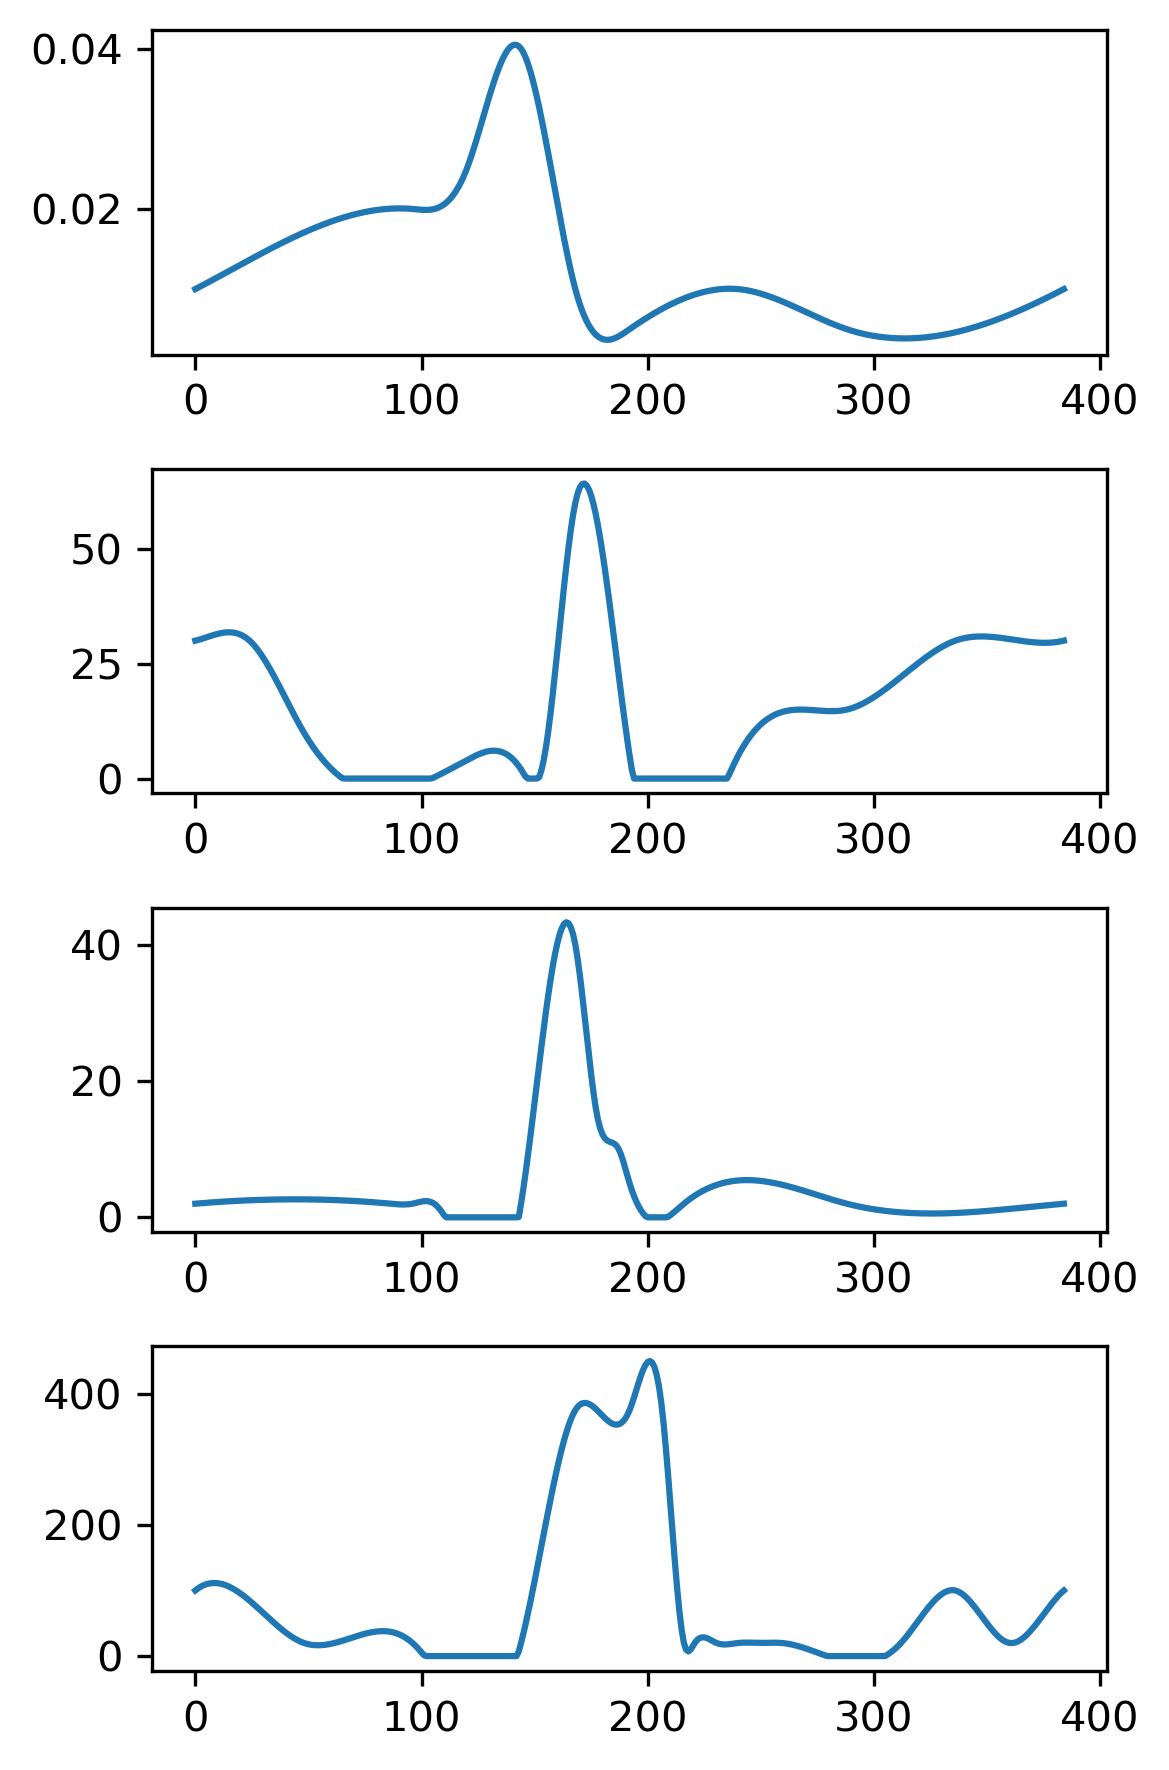

In [94]:
fig, [ax1,ax2,ax3,ax4] = plt.subplots(4,1, figsize=(4,6), dpi=300)
ax1.plot(X_conc[:,0])
ax2.plot(X_conc[:,1])
ax3.plot(X_conc[:,2])
ax4.plot(X_conc[:,3])
plt.tight_layout()

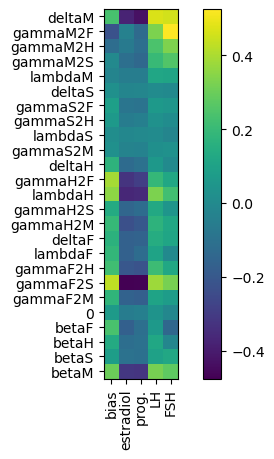

In [95]:
weight_array = np.zeros([5,25])
for i, k in enumerate(w.keys()):
    weight_array[:,i] = w[k]
def normalize_rows(x):
  """Normalizes each row of a NumPy array to have unit length."""
  norm = np.sqrt(np.sum(x**2, axis=1, keepdims=True))
  return x / norm
plt.imshow(normalize_rows(weight_array).T)
plt.yticks(np.arange(25), labels=symbol_matrix.flatten())
plt.xticks(np.arange(5), labels=['bias','estradiol','prog.','LH','FSH'], rotation=90)
plt.colorbar()

In [109]:
def calc_intensity(t, pops, params):
    # Intensity function and demographic functions combined into single func
    # Should return the values for birth*population, etc. as numbers not as rates
    # c == Current hormone concentrations (not including bias term

    alltimes = np.arange(0,96.25,0.25)
    ind, _ = find_closest_timestamp(alltimes, t)
    c = X_conc[ind,:]

    # augment concentrations by inserting a 1.0 to use full bias term
    c_aug = np.insert(c, 0, 1.0)

    # Current populations
    F, H, S, M = pops

    # Ignore lambda values because these represent staibility not a real transition
    # The population intensites, lambda(t), of the point process are the expected rate of occurrence
    # of events at a particular time t
    ppintens = np.array([
        params['w_betaF'] @ c_aug,              # betaF
        params['w_betaH'] @ c_aug,              # betaH
        params['w_betaS'] @ c_aug,              # betaS
        params['w_betaM'] @ c_aug,              # betaM
        (params['w_deltaF'] @ c_aug) * F,       # deltaF
        (params['w_deltaH'] @ c_aug) * H,       # deltaF
        (params['w_deltaS'] @ c_aug) * S,       # deltaF
        (params['w_deltaM'] @ c_aug) * M,       # deltaF
        (params['w_gammaH2F'] @ c_aug) * H,     # gammaHF
        (params['w_gammaS2F'] @ c_aug) * S,     # gammaSF
        (params['w_gammaM2F'] @ c_aug) * M,     # gammaMF
        (params['w_gammaF2H'] @ c_aug) * F,     # gammaFH
        (params['w_gammaF2S'] @ c_aug) * F,     # gammaFS
        (params['w_gammaF2M'] @ c_aug) * F,     # gammaFM
        (params['w_gammaS2H'] @ c_aug) * S,     # gammaSH
        (params['w_gammaM2H'] @ c_aug) * M,     # gammaMH
        (params['w_gammaH2S'] @ c_aug) * H,     # gammaHS
        (params['w_gammaM2S'] @ c_aug) * M,     # gammaMS
        (params['w_gammaH2M'] @ c_aug) * H,     # gammaHM
        (params['w_gammaS2M'] @ c_aug) * S,     # gammaSM
    ])
    return ppintens

In [110]:
def nhpp(tottime, pops, param, calc_intensity, timeleft, maxT=96):

    Y = random.random()
    def f(X):
        # Integrate sum of intensities from 0 to X
        integral, _ = scipy.integrate.quad(lambda x: sum(calc_intensity(tottime+x % maxT, pops, param)), 0, X, limit=200)
        return 1 - math.exp(-integral) - Y
    try:
        sol = scipy.optimize.root_scalar(f, bracket=[0, timeleft], method='bisect', xtol=1e-5)
        return sol.root
    except ValueError:
        # In case no root is found, return a value greater than timeleft
        return timeleft + 1

In [111]:
params = w.copy()

def gillespie_plus(init, times, calc_intensity, nhpp_func):

    pproc = get_state_change_mat()

    tottime = times[0]
    tinc = len(times)
    pops = np.array(init, dtype=float)
    results = np.zeros((tinc, len(pops)))
    results[0, :] = pops.copy()

    i = 1
    while i < tinc:
        
        results[i, :] = results[i-1, :].copy()
        
        while tottime <= times[i]:

            tau = nhpp_func(tottime, pops, params, calc_intensity, times[-1]-tottime)
            tottime += tau

            # Recalculate intensities for the new time.
            intentemp = calc_intensity(tottime, pops, params)

            # Handle negative intensities (before normalizing by the sum) by shifting the up so the lowest
            # intensity is zero. Once scaled by the sum, they'll still sum to 1.
            # if np.nanmin(intentemp) < 0:
            #     intentemp += - np.nanmin(intentemp)

            probabilities = np.array(intentemp) / np.sum(intentemp)

            _choice = np.arange(pproc.shape[0])
            _probs = probabilities.flatten()
            event_index = np.random.choice(_choice, p=_probs)
            
            if tottime > times[i]:
                results[i, :] = pops.copy()
                pops = pops + pproc[event_index, :]
                break
            else:
                pops = pops + pproc[event_index, :]

            pops[pops<0] = 0
        i += 1

    return np.column_stack((times, results))

In [113]:
# Initial population sizes
init = [1,6,23,2]

# Time grid: from 0 to 20 in steps of 1
# 6 passes through full estrous cycle
times = np.arange(0, 96*6+.25, 0.25)

# Run simulation using gillespie_plus (nonhomogeneous Poisson process sampler)
# res_list = []
# for i in tqdm(range(8)):
    # res_gillespie_plus = gillespie_plus(init, times, inten, state_change_matrix, nhpp)
    # res_list.append(res_gillespie_plus)

In [ ]:
res_gillespie_plus = gillespie_plus(init, times, calc_intensity, nhpp)

/var/folders/nf/336h2vrj3gx4f2_bc7f8p98h0000gn/T/ipykernel_57888/4280710950.py:6: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = scipy.integrate.quad(lambda x: sum(calc_intensity(tottime+x % maxT, pops, param)), 0, X, limit=200)
